In [1]:
#!/usr/bin/env python3
r"""
In this example we both a stage 1 and stage 2 optimization problems using the
single stage approach of R. Jorge et al in https://arxiv.org/abs/2302.10622
The objective function in this case is J = J_stage1 + coils_objective_weight*J_stage2
To accelerate convergence, a stage 2 optimization is done before the single stage one.
Rogerio Jorge, April 2023
"""
import os
import numpy as np
from pathlib import Path
from scipy.optimize import minimize
from simsopt.util import MpiPartition, proc0_print, comm_world
from simsopt._core.derivative import Derivative
from simsopt.mhd import Vmec, QuasisymmetryRatioResidual
from simsopt._core.finite_difference import MPIFiniteDifference
from simsopt.field import BiotSavart, Current, coils_via_symmetries
from simsopt.objectives import SquaredFlux, QuadraticPenalty, LeastSquaresProblem
from simsopt.geo import (CurveLength, CurveCurveDistance, MeanSquaredCurvature,
                         LpCurveCurvature, ArclengthVariation, curves_to_vtk, create_equally_spaced_curves)
from simsopt.geo import CurveCWSFourierFree
from simsopt.geo import Curve2D
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [2]:
##########################################################################################
############## Input parameters
##########################################################################################

mpi = MpiPartition()

MAXITER_stage_2 = 1e3
MAXITER_single_stage = 1e3
max_mode = 1
vmec_input_filename = 'input.nfp4_QH_warm_start'
ncoils = 3
aspect_ratio_target = 7.0
CC_THRESHOLD = 0.08
LENGTH_THRESHOLD = 3.3
CURVATURE_THRESHOLD = 7
MSC_THRESHOLD = 10

wport = 1E-2 #1E-4
wdd = 1E6
#wco = 1E1
#wph = 1E3
warc = 1E-1
wufp = 1E-1



nphi_VMEC = 34
ntheta_VMEC = 34
nmodes_coils = 7

mean_iota_target = 0.33
iota_weight = 1E3

coils_objective_weight = 1e+3
aspect_ratio_weight = 1.0
diff_method = "forward"
R0 = 1.0
R1 = 0.6
quasisymmetry_target_surfaces = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
finite_difference_abs_step = 1e-7
finite_difference_rel_step = 0
JACOBIAN_THRESHOLD = 1e4
LENGTH_CON_WEIGHT = 0.1  # Weight on the quadratic penalty for the curve length
LENGTH_WEIGHT = 1e-8  # Weight on the curve lengths in the objective function
CC_WEIGHT = 1e+0  # Weight for the coil-to-coil distance penalty in the objective function
CURVATURE_WEIGHT = 1e-3  # Weight for the curvature penalty in the objective function
MSC_WEIGHT = 1e-3  # Weight for the mean squared curvature penalty in the objective function
ARCLENGTH_WEIGHT = 1e-9  # Weight for the arclength variation penalty in the objective function
##########################################################################################
##########################################################################################

In [3]:
vmec_verbose = False

# Stage 1
print(f' Using vmec input file {vmec_input_filename}')
vmec = Vmec(vmec_input_filename, mpi=mpi, verbose=vmec_verbose, nphi=nphi_VMEC, ntheta=ntheta_VMEC, range_surface='half period')
surf = vmec.boundary

#Stage 2
base_curves = create_equally_spaced_curves(ncoils, surf.nfp, stellsym=True, R0=R0, R1=R1, order=nmodes_coils, numquadpoints=128)
base_currents = [Current(1) * 1e5 for _ in range(ncoils)]
base_currents[0].fix_all()

# Save initial surface and coil data
coils = coils_via_symmetries(base_curves, base_currents, surf.nfp, True)
curves = [c.curve for c in coils]
bs = BiotSavart(coils)
bs.set_points(surf.gamma().reshape((-1, 3)))
Bbs = bs.B().reshape((nphi_VMEC, ntheta_VMEC, 3))
BdotN_surf = np.sum(Bbs * surf.unitnormal(), axis=2)

curves_to_vtk(curves, "curves_init")
pointData = {"B_N": BdotN_surf[:, :, None]}
surf.to_vtk("surf_init", extra_data=pointData)

 Using vmec input file input.nfp4_QH_warm_start


In [4]:
#Define one port
port_order = 1
port_qpts = 64

c2dport = Curve2D(port_qpts, port_order )
port_curve = CurveCWSFourierFree(
    c2dport,
    vmec.boundary
)
nfp = vmec.boundary.nfp
dphi = 1/(2*nfp) * 1/ncoils
iphi0 = 0
port_curve.curve.set('phic(0)', iphi0*dphi)
port_curve.curve.set('phic(1)', dphi/3.0)
port_curve.curve.set('thetac(0)', 0.0)
port_curve.curve.set('thetas(1)', 0.05)

Text(0, 0.5, 'z')

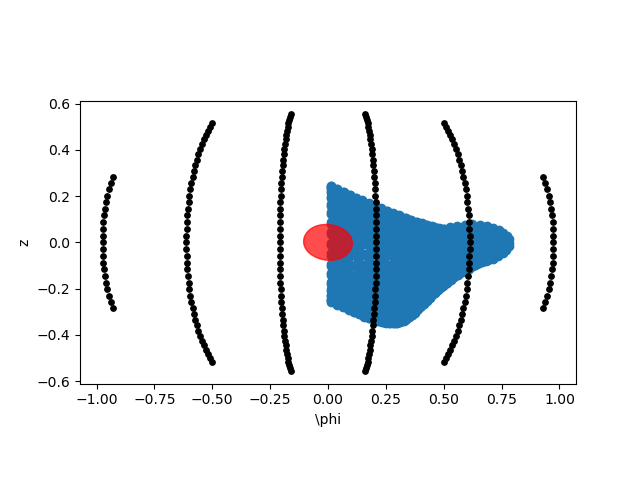

In [5]:
def project(x, x0):
    phic = np.arctan2(x0[1], x0[0])
    unit_normal = np.array([np.cos(phic), np.sin(phic), np.zeros(phic.shape)])
    unit_tangent = np.array([-np.sin(phic), np.cos(phic), np.zeros(phic.shape)])
    unit_z = np.array([np.zeros(phic.shape), np.zeros(phic.shape), np.ones(phic.shape)])

    M = np.array([unit_normal,unit_tangent,unit_z]).transpose()
    invM = np.linalg.inv(M)
    
    return np.einsum('ij,...j->...i',invM,x-x0)

x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(surf.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [6]:
Jf = SquaredFlux(surf, bs, definition="local")
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=len(curves))
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for i, c in enumerate(base_curves)]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
Jals = [ArclengthVariation(c) for c in base_curves]
J_LENGTH = LENGTH_WEIGHT * sum(Jls)
J_CC = CC_WEIGHT * Jccdist
J_CURVATURE = CURVATURE_WEIGHT * sum(Jcs)
J_MSC = MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for i, J in enumerate(Jmscs))
J_ALS = ARCLENGTH_WEIGHT * sum(Jals)
J_LENGTH_PENALTY = LENGTH_CON_WEIGHT * sum([QuadraticPenalty(Jls[i], LENGTH_THRESHOLD) for i in range(len(base_curves))])
JF = Jf + J_CC + J_LENGTH + J_LENGTH_PENALTY + J_CURVATURE + J_MSC

# Port relavant penalties
Jxyarea = ProjectedEnclosedArea( port_curve, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( curves, port_curve, 0.05, projection='zphi' )
Jconvex = ProjectedCurveConvexity( port_curve, projection='zphi' )
Jarc = ArclengthVariation( port_curve )
Jufp = DirectedFacingPort(port_curve, projection='r')
Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex

Jport = wport * Jport


In [7]:
##########################################################################################
# Initial stage 2 optimization
##########################################################################################
## The function fun_coils defined below is used to only optimize the coils at the beginning
## and then optimize the coils and the surface together. This makes the overall optimization
## more efficient as the number of iterations needed to achieve a good solution is reduced.


def fun_coils(dofss, info):
    info['Nfeval'] += 1
    c2dport.x = dofss[:number_c2d_dofs]
    JF.x = dofss[number_c2d_dofs:]
    J = JF.J() + Jport.J()
    
    grad_port = Jport.dJ()[:number_c2d_dofs]
    grad = np.concatenate((grad_port, JF.dJ()))

    
    if mpi.proc0_world:
        jf = Jf.J()
        Bbs = bs.B().reshape((nphi_VMEC, ntheta_VMEC, 3))
        BdotN_surf = np.sum(Bbs * surf.unitnormal(), axis=2)
        BdotN = np.mean(np.abs(BdotN_surf))
        # BdotNmax = np.max(np.abs(BdotN_surf))
        outstr = f"fun_coils#{info['Nfeval']} - J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"  # , B·n max={BdotNmax:.1e}"
        outstr += f", ║∇J coils║={np.linalg.norm(JF.dJ()):.1e}, C-C-Sep={Jccdist.shortest_distance():.2f}"
        cl_string = ", ".join([f"{j.J():.1f}" for j in Jls])
        kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
        msc_string = ", ".join(f"{j.J():.1f}" for j in Jmscs)
        outstr += f" lengths=sum([{cl_string}])={sum(j.J() for j in Jls):.1f}, curv=[{kap_string}],msc=[{msc_string}]"
        print(outstr)
    
    return J, grad
##########################################################################################
##########################################################################################
## The function fun defined below is used to optimize the coils and the surface together.


def fun(dofs, prob_jacobian=None, info={'Nfeval': 0}):
    info['Nfeval'] += 1
    c2dport.x = dofs[:number_c2d_dofs]
    JF.x = dofs[number_c2d_dofs:-number_vmec_dofs]
    prob.x = dofs[-number_vmec_dofs:]
    bs.set_points(surf.gamma().reshape((-1, 3)))
    
    J_stage_1 = prob.objective()
    J_stage_2 = coils_objective_weight * JF.J()
    J_port = Jport.J()
    J = J_stage_1 + J_stage_2 + J_port
    
    if J > JACOBIAN_THRESHOLD or np.isnan(J):
        proc0_print(f"Exception caught during function evaluation with J={J}. Returning J={JACOBIAN_THRESHOLD}")
        J = JACOBIAN_THRESHOLD
        grad_with_respect_to_surface = [0] * number_vmec_dofs
        grad_with_respect_to_coils = [0] * len(JF.x)
        grad_with_respect_to_c2d = [0] * number_c2d_dofs

        grad = np.concatenate((grad_with_respect_to_c2d, grad_with_respect_to_coils, grad_with_respect_to_surface))
    
    else:
        proc0_print(f"fun#{info['Nfeval']}: Objective function = {J:.4f}")
        prob_dJ = prob_jacobian.jac(prob.x)
        ## Finite differences for the second-stage objective function
        coils_dJ = JF.dJ()
        ## Mixed term - derivative of squared flux with respect to the surface shape
        n = surf.normal()
        absn = np.linalg.norm(n, axis=2)
        B = bs.B().reshape((nphi_VMEC, ntheta_VMEC, 3))
        dB_by_dX = bs.dB_by_dX().reshape((nphi_VMEC, ntheta_VMEC, 3, 3))
        Bcoil = bs.B().reshape(n.shape)
        unitn = n * (1./absn)[:, :, None]
        Bcoil_n = np.sum(Bcoil*unitn, axis=2)
        mod_Bcoil = np.linalg.norm(Bcoil, axis=2)
        B_n = Bcoil_n
        B_diff = Bcoil
        B_N = np.sum(Bcoil * n, axis=2)
        assert Jf.definition == "local"
        dJdx = (B_n/mod_Bcoil**2)[:, :, None] * (np.sum(dB_by_dX*(n-B*(B_N/mod_Bcoil**2)[:, :, None])[:, :, None, :], axis=3))
        dJdN = (B_n/mod_Bcoil**2)[:, :, None] * B_diff - 0.5 * (B_N**2/absn**3/mod_Bcoil**2)[:, :, None] * n
        deriv = surf.dnormal_by_dcoeff_vjp(dJdN/(nphi_VMEC*ntheta_VMEC)) + surf.dgamma_by_dcoeff_vjp(dJdx/(nphi_VMEC*ntheta_VMEC))
        mixed_dJ = Derivative({surf: deriv})(surf)
        port_dJ = Jport.dJ()
        port_dJ_wrt_c2d = port_dJ[:number_c2d_dofs]
        port_dJ_wrt_curve_and_surf = port_dJ[number_c2d_dofs:]
        ## Put both gradients together
        grad_with_respect_to_coils = coils_objective_weight * coils_dJ
        grad_with_respect_to_surface = np.ravel(prob_dJ) + coils_objective_weight * mixed_dJ
        grad_coil_surf = np.concatenate((grad_with_respect_to_coils, grad_with_respect_to_surface))
        grad_curr = grad_coil_surf[:3]
        grad_others = grad_coil_surf[3:]
        
        grad = np.concatenate((
            port_dJ_wrt_c2d, 
            grad_curr,
            port_dJ_wrt_curve_and_surf+grad_others
        ))
    
    return J, grad

In [8]:
qs = QuasisymmetryRatioResidual(vmec, quasisymmetry_target_surfaces, helicity_m=1, helicity_n=-1)
objective_tuple = [(vmec.aspect, aspect_ratio_target, aspect_ratio_weight), (qs.residuals, 0, 1), (vmec.mean_iota, mean_iota_target, iota_weight)]
prob = LeastSquaresProblem.from_tuples(objective_tuple)

In [9]:
len(prob.full_x)

54

In [10]:
# Define dofs
surf.fix_all()
surf.fixed_range(mmin=0, mmax=max_mode, nmin=-max_mode, nmax=max_mode, fixed=False)
surf.fix("rc(0,0)")

c2dport.unfix_all()
for c in base_curves:
    c.unfix_all()
for c in base_currents:
    c.unfix_all()

dofs = np.concatenate((c2dport.x, JF.x, prob.x))

number_vmec_dofs = int(len(prob.x))
number_c2d_dofs = int(len(c2dport.x))
number_curve_dofs = int(len(JF.x))

x = dofs[:number_c2d_dofs+number_curve_dofs]
infos = dict({'Nfeval': 0})

fun_coils(x, infos)

fun_coils#1 - J=7.9e-01, Jf=6.7e-01, ⟨B·n⟩=1.9e-01, ║∇J coils║=1.1e+00, C-C-Sep=0.10 lengths=sum([3.8, 3.8, 3.8])=11.3, curv=[1.7, 1.7, 1.7],msc=[2.8, 2.8, 2.8]


(Array(0.78561061, dtype=float64),
 array([-3.72965547e-19, -8.92861326e-03, -4.72236437e-04, -2.68882139e-20,
         8.13120286e-05,  4.22834000e-05,  7.31725946e-02, -4.34561131e-03,
        -6.88269833e-02, -2.19094762e-01,  2.23152975e-02,  2.27961113e-01,
        -2.23761218e-02, -1.20054095e-01,  2.57427966e-02,  5.46955935e-02,
         1.24603728e-02,  7.35595828e-04,  7.30707875e-04, -4.03836184e-03,
        -2.73166890e-03,  2.76035344e-04, -7.17540979e-04,  3.38157771e-04,
        -1.08771896e-01,  8.49833312e-03, -1.62490385e-01, -2.30789350e-01,
         4.20186437e-02,  2.50609454e-03,  6.33885680e-02,  1.09700214e-02,
         6.10598085e-03,  6.52555540e-03, -1.04935426e-02, -3.05936409e-03,
        -3.27562513e-03, -1.02697222e-03,  7.43517010e-04,  1.38992168e-01,
        -6.78657367e-02, -2.32336421e-02,  1.17875476e-01, -8.66834220e-02,
        -7.44343526e-02,  2.06176098e-02, -2.80670101e-03,  2.05890283e-02,
         6.55932379e-03,  3.65585210e-03,  1.12652682

In [11]:
#############################################################
## STAGE II
#############################################################
surf.fix_all()

bs.set_points(surf.gamma().reshape((-1, 3)))

Jf = SquaredFlux(surf, bs, definition="local")
proc0_print(f"Aspect ratio before optimization: {vmec.aspect()}")
proc0_print(f"Mean iota before optimization: {vmec.mean_iota()}")
proc0_print(f"Quasisymmetry objective before optimization: {qs.total()}")
proc0_print(f"Magnetic well before optimization: {vmec.vacuum_well()}")
proc0_print(f"Squared flux before optimization: {Jf.J()}")
proc0_print(f'  Performing stage 2 optimization with ~{MAXITER_stage_2} iterations')

res = minimize(fun_coils, dofs[:-number_vmec_dofs], jac=True, args=({'Nfeval': 0}), method='L-BFGS-B', options={'maxiter': MAXITER_stage_2, 'maxcor': 300}, tol=1e-12)

Aspect ratio before optimization: 7.000345969477051
Mean iota before optimization: -1.0487636715728472
Quasisymmetry objective before optimization: 0.2998810826252466
Magnetic well before optimization: -0.17977506603144025
Squared flux before optimization: 0.6743711677681443
  Performing stage 2 optimization with ~1000.0 iterations
fun_coils#1 - J=7.9e-01, Jf=6.7e-01, ⟨B·n⟩=1.9e-01, ║∇J coils║=1.1e+00, C-C-Sep=0.10 lengths=sum([3.8, 3.8, 3.8])=11.3, curv=[1.7, 1.7, 1.7],msc=[2.8, 2.8, 2.8]
fun_coils#2 - J=2.6e-01, Jf=1.9e-01, ⟨B·n⟩=8.5e-02, ║∇J coils║=2.4e+00, C-C-Sep=0.01 lengths=sum([4.1, 4.0, 3.8])=11.9, curv=[6.7, 8.7, 7.4],msc=[7.5, 7.0, 7.4]
fun_coils#3 - J=3.1e-01, Jf=2.5e-01, ⟨B·n⟩=9.5e-02, ║∇J coils║=1.2e+00, C-C-Sep=0.07 lengths=sum([3.6, 3.6, 3.5])=10.7, curv=[2.6, 3.0, 2.8],msc=[4.1, 4.1, 4.4]
fun_coils#4 - J=8.6e+00, Jf=6.9e-01, ⟨B·n⟩=1.6e-01, ║∇J coils║=2.2e+01, C-C-Sep=0.04 lengths=sum([9.3, 10.0, 10.3])=29.6, curv=[15.2, 36.8, 25.6],msc=[5.3, 10.5, 13.6]
fun_coils#5 - J

In [12]:
print(res.message)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


Text(0, 0.5, 'z')

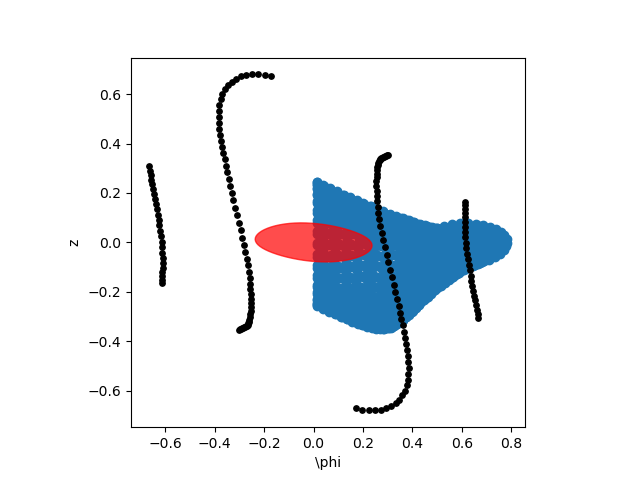

In [13]:
x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(surf.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [14]:
surf.fixed_range(mmin=0, mmax=max_mode, nmin=-max_mode, nmax=max_mode, fixed=False)
surf.fix("rc(0,0)")

In [15]:
bs.set_points(surf.gamma().reshape((-1, 3)))
Bbs = bs.B().reshape((nphi_VMEC, ntheta_VMEC, 3))
BdotN_surf = np.sum(Bbs * surf.unitnormal(), axis=2)

curves_to_vtk(curves, "curves_after_stage2")
pointData = {"B_N": BdotN_surf[:, :, None]}
surf.to_vtk("surf_after_stage2", extra_data=pointData)

proc0_print(f'  Performing single stage optimization with ~{MAXITER_single_stage} iterations')

with MPIFiniteDifference(prob.objective, mpi, diff_method=diff_method, abs_step=finite_difference_abs_step, rel_step=finite_difference_rel_step) as prob_jacobian:
    if mpi.proc0_world:
        res = minimize(fun, dofs, args=(prob_jacobian, {'Nfeval': 0}), jac=True, method='BFGS', options={'maxiter': MAXITER_single_stage}, tol=1e-15)

  Performing single stage optimization with ~1000.0 iterations
fun#1: Objective function = 2687.0235


Function evaluation failed for <bound method Vmec.aspect of Vmec1 (nfp=4 mpol=3 ntor=3)>


Exception caught during function evaluation with J=4.535299999998633e+28. Returning J=10000.0
fun#3: Objective function = 826.3287
fun#4: Objective function = 3662.8880
fun#5: Objective function = 360.1231


Function evaluation failed for <bound method Vmec.aspect of Vmec1 (nfp=4 mpol=3 ntor=3)>


Exception caught during function evaluation with J=4.535299999998633e+28. Returning J=10000.0
fun#7: Objective function = 346.8554
fun#8: Objective function = 324.2532
fun#9: Objective function = 258.4912
fun#10: Objective function = 1644.1001
fun#11: Objective function = 238.6390
fun#12: Objective function = 1847.7335
fun#13: Objective function = 231.3002
fun#14: Objective function = 216.7737
fun#15: Objective function = 180.8139
fun#16: Objective function = 629.3592
fun#17: Objective function = 171.7870
fun#18: Objective function = 162.3282
fun#19: Objective function = 169.5263
fun#20: Objective function = 156.8895
fun#21: Objective function = 148.1994
fun#22: Objective function = 332.6807
fun#23: Objective function = 146.2575
fun#24: Objective function = 143.5228
fun#25: Objective function = 139.1110
fun#26: Objective function = 130.1777
fun#27: Objective function = 359.6780
fun#28: Objective function = 122.4591
fun#29: Objective function = 247.7618
fun#30: Objective function = 115.

In [16]:
res.message

'Maximum number of iterations has been exceeded.'

Text(0, 0.5, 'z')

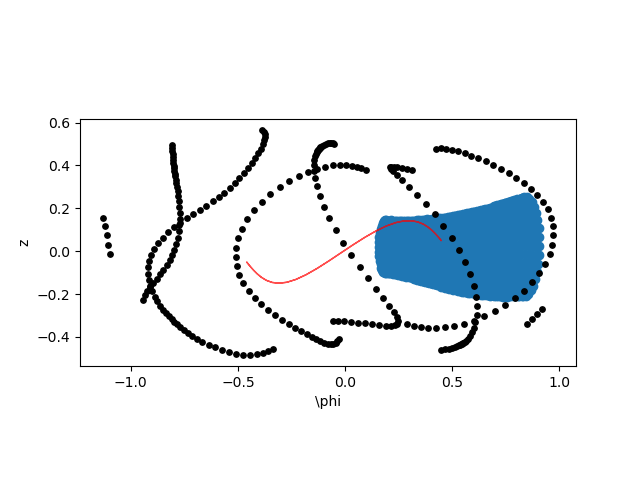

In [17]:
x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(surf.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

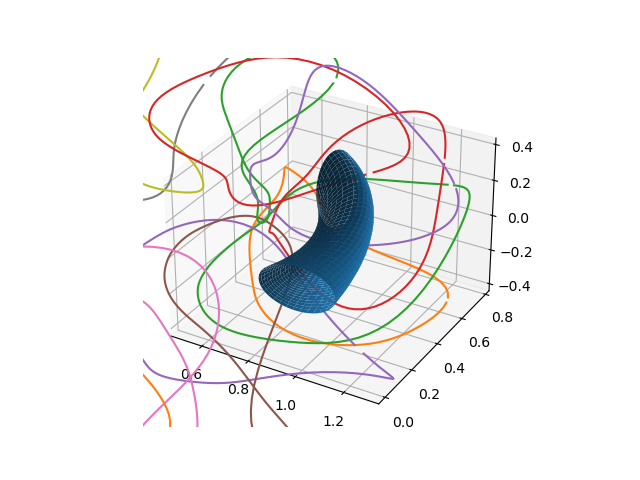

In [18]:
surf.plot(show=False, close=True)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

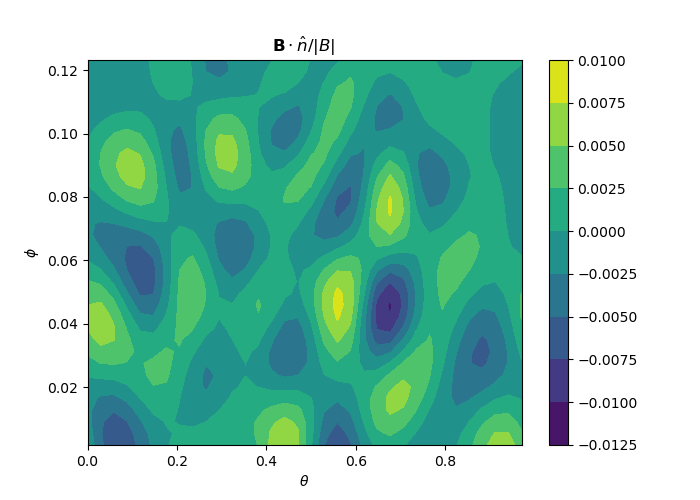

In [19]:
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [20]:
mpi.comm_world.Bcast(dofs, root=0)
Bbs = bs.B().reshape((nphi_VMEC, ntheta_VMEC, 3))
BdotN_surf = np.sum(Bbs * surf.unitnormal(), axis=2)
if comm_world.rank == 0:
    curves_to_vtk(curves, "curves_opt")
    pointData = {"B_N": BdotN_surf[:, :, None]}
    surf.to_vtk("surf_opt", extra_data=pointData)
bs.save("biot_savart_opt.json")
vmec.write_input('input.final')
proc0_print(f"Aspect ratio after optimization: {vmec.aspect()}")
proc0_print(f"Mean iota after optimization: {vmec.mean_iota()}")
proc0_print(f"Quasisymmetry objective after optimization: {qs.total()}")
proc0_print(f"Magnetic well after optimization: {vmec.vacuum_well()}")
proc0_print(f"Squared flux after optimization: {Jf.J()}")
BdotN_surf = np.sum(Bbs * surf.unitnormal(), axis=2)
BdotN = np.mean(np.abs(BdotN_surf))
BdotNmax = np.max(np.abs(BdotN_surf))
outstr = f"Coil parameters: ⟨B·n⟩={BdotN:.1e}, B·n max={BdotNmax:.1e}"
outstr += f", ║∇J coils║={np.linalg.norm(JF.dJ()):.1e}, C-C-Sep={Jccdist.shortest_distance():.2f}"
cl_string = ", ".join([f"{j.J():.1f}" for j in Jls])
kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
msc_string = ", ".join(f"{j.J():.1f}" for j in Jmscs)
outstr += f" lengths=sum([{cl_string}])={sum(j.J() for j in Jls):.1f}, curv=[{kap_string}], msc=[{msc_string}]"
proc0_print(outstr)

Aspect ratio after optimization: 7.217860192142005
Mean iota after optimization: 0.32926576725494033
Quasisymmetry objective after optimization: 1.0184493148804101
Magnetic well after optimization: -0.03496888890377779
Squared flux after optimization: 2.0975515765930922e-05
Coil parameters: ⟨B·n⟩=1.9e-03, B·n max=9.3e-03, ║∇J coils║=9.3e-04, C-C-Sep=0.08 lengths=sum([3.3, 3.3, 3.3])=9.9, curv=[6.5, 6.3, 5.6], msc=[10.0, 10.0, 10.0]


In [ ]:
from simsopt.geo import SurfaceRZFourier
from simsopt.field import SurfaceClassifier, \
    particles_to_vtk, compute_fieldlines, LevelsetStoppingCriterion, plot_poincare_data

nphi=64
ntheta=55

# Run and plot Poincare section
surf = SurfaceRZFourier.from_vmec_input('input.final', range="half period", nphi=nphi, ntheta=ntheta)
surf1 = SurfaceRZFourier.from_vmec_input('input.final', range="half period", nphi=nphi, ntheta=ntheta)
surf1.extend_via_normal(0.1)
nfp = surf.nfp

Rmaj = surf.major_radius()
r0 = surf.minor_radius()
sc_fieldline = SurfaceClassifier(surf1, h=0.01, p=3)
nfieldlines = 50
tmax_fl = 100
degree = 4

def trace_fieldlines(bfield,label):
    # Set up initial conditions - 
    R0 = np.linspace(1.15, 1.25, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis, stopping_criteria=[LevelsetStoppingCriterion(sc_fieldline.dist)])
    plot_poincare_data(fieldlines_phi_hits, phis, 'poincare_final', dpi=150,surf=surf,mark_lost=True)
    return fieldlines_phi_hits

hits = trace_fieldlines(bs, 'vmec')